# A small fine-tuning experiment with OpenAI

In [72]:
TRAIN_PATH="/tmp/finetuning_train.jsonl"
TEST_PATH="/tmp/finetuning_test.jsonl"
OUTPUT_PATH="/tmp/output.jsonl"

## Install somme packages

In [ ]:
!pip install python-dotenv numpy pandas matplotlib huggingface_hub datasets openai tiktoken

## Generate input files

In [57]:
from dotenv import load_dotenv
load_dotenv()

True

In [58]:
from datasets import load_dataset

dataset = load_dataset("LeoTungAnh/electricity_hourly")

In [59]:
dataset["train"]

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 370
})

In [60]:
# import os
# from huggingface_hub import login

# login(os.getenv("HF_TOKEN"))
# dataset = load_dataset("EDS-lab/electricity-demand", "demand")

In [61]:
from typing import Any
import json

SYSTEM_PROMPT = "Given a meter ID, you return a series of hourly consumptions given as a json string."

def format(series: Any) -> str:
    return json.dumps({"messages": [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": json.dumps({"item_id": series["item_id"]})},
        {"role": "assistant", "content": json.dumps({"consumption": [round(1000*x)/1000 for x in series["target"][:100]]})}
    ]})+"\n"

with open(TRAIN_PATH, "w") as f:
    for series in dataset["train"]:
        f.write(format(series))

with open(TEST_PATH, "w") as f:
    for series in dataset["test"]:
        f.write(format(series))

## Validate the data

In [99]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

In [100]:
data_path = TRAIN_PATH

# Load the dataset
with open(data_path, "r", encoding="utf-8") as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 370
First example:
{'role': 'system', 'content': 'Given a meter ID, you return a series of hourly consumptions given as a json string.'}
{'role': 'user', 'content': '{"item_id": "MT_001"}'}
{'role': 'assistant', 'content': '{"consumption": [-0.194, -0.089, -0.194, -0.089, -0.141, -0.141, -0.089, -0.194, -0.456, -0.036, 1.751, 0.7, 0.122, -0.562, 0.7, 1.068, -0.509, 1.015, 1.699, -0.194, 0.437, 2.172, 1.12, 0.7, -0.246, -0.194, -0.246, -0.194, -0.246, -0.299, -0.351, -0.351, 1.383, 1.909, 1.856, 2.434, 2.382, 1.699, 2.645, 1.856, 2.855, 0.647, 1.12, -0.246, 0.858, 0.963, 0.279, 0.91, -0.194, -0.246, -0.194, -0.246, -0.351, -0.299, -0.299, 0.174, 1.856, 1.804, 1.699, 2.014, 2.014, 0.7, 1.015, 2.014, 2.96, -0.036, 2.224, 0.332, 0.858, 2.066, 0.858, 1.331, -0.089, -0.036, -0.141, -0.089, -0.141, -0.194, -0.194, 0.174, 1.751, 2.224, 2.54, 2.172, 1.856, 2.277, 0.437, 0.332, 1.751, 3.328, 2.277, 0.174, 0.069, 2.277, 0.647, 0.91, 0.91, 0.91, 0.752, 2.066]}'}


In [101]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [102]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [103]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")



Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 547, 547
mean / median: 547.0, 547.0
p5 / p95: 547.0, 547.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 504, 504
mean / median: 504.0, 504.0
p5 / p95: 504.0, 504.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


In [104]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~202390 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~607170 tokens


## Finetune

In [38]:
from openai import OpenAI

client = OpenAI()

def upload_files():
  with open(TRAIN_PATH, "rb") as f:
    train_file = client.files.create(file=f, purpose="fine-tune")

  with open(TEST_PATH, "rb") as f:
    test_file = client.files.create(file=f, purpose="fine-tune")

  return (train_file, test_file)


train_file, test_file = upload_files()

In [42]:
fine_tuning_job = client.fine_tuning.jobs.create(
  training_file=train_file.id,
  hyperparameters={"batch_size": 2, "learning_rate_multiplier":2, "n_epochs": 10},
  validation_file=test_file.id,
  suffix="arena",
  model="gpt-3.5-turbo"
)

## Wait for the training to finish

In [49]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=fine_tuning_job.id, limit=1).data[0].message

'The job has successfully completed'

In [52]:
model = client.fine_tuning.jobs.retrieve(fine_tuning_job.id).fine_tuned_model
model

'ft:gpt-3.5-turbo-0125:sarus:arena:9UVYbwyK'

## Generate new synthetic records

In [79]:
def format_query(item_id: int) -> Any:
    return {"model": model, "temperature": 1.1, "messages": [
        {"role": "system", "content": "Given a meter ID, you return a series of hourly consumptions given as a json string."},
        {"role": "user", "content": json.dumps({"item_id": f"MT_{item_id}"})},
    ]}

completion = client.chat.completions.create(**format_query(10))

print(completion.choices[0].message)

ChatCompletionMessage(content='{"consumption": [-1.507, -1.479, -1.507, -1.526, -1.544, -1.507, -1.562, -1.562, -1.562, -1.661, -1.588, -1.625, -0.811, -1.562, -1.655, -1.643, -1.68, -1.634, -1.592, -1.468, -1.58, -1.497, -1.507, -1.499, -1.544, -1.479, -1.479, -1.507, -1.544, -1.516, -1.269, -0.314, 0.248, 0.4, 0.171, 1.062, 1.025, 0.376, 0.248, 0.233, 0.29, 0.267, 1.283, 1.711, 1.712, 0.844, -0.367, -1.107, -1.101, -1.172, -1.142, -1.072, -0.871, -0.9, -0.594, -0.075, 0.19, 0.018, 0.164, 0.087, 0.201, -0.023, 0.072, 0.026, 0.072, 0.493, 0.95, 1.181, 1.005, 0.729, -0.253, -1.046, -1.107, -1.166, -1.119, -1.119, -1.22, -1.25, -0.526, 0.087, 0.17, 0.026, 0.044, -0.011, 0.07, -0.023, 0.048, 0.072, 0.072, 0.548, 1.018, 0.874, 0.597, -0.429, -1.154, -1.214, -1.232, -1.178, -1.232, -1.179]}', role='assistant', function_call=None, tool_calls=None)


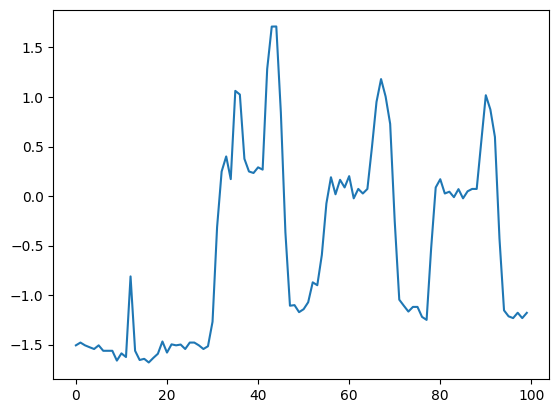

In [80]:
import matplotlib.pyplot as plt

def data_from_response(resp: Any) -> list[float]:
    return json.loads(resp.choices[0].message.content)["consumption"]

plt.plot(data_from_response(completion))

In [89]:
# Generate a few series
import random

with open(OUTPUT_PATH, "w") as f:
    for i in range(10):
        print(i)
        completion = client.chat.completions.create(**format_query(random.randint(400,800)))# Avoid the range from original data
        print(completion.choices[0].message.content)
        try:
            f.write(json.dumps(data_from_response(completion))+"\n")
        except:
            print("malformed")
            pass

0
{"consumption": [4.275, 1.277, -0.201, -0.667, -0.85, -0.618, 0.366, 1.844, 2.87, 2.111, 0.63, 0.366, 0.097, 1.018, 0.867, 1.275, 1.461, 1.43, 1.925, 1.949, 2.004, 0.851, 0.289, -0.331, -0.518, -0.915, -1.124, -1.171, -1.155, -0.915, -0.331, 0.796, 1.461, 3.062, 2.428, 2.62, 1.133, 1.653, 2.745, 2.588, 3.147, 3.697, 3.536, 3.4, 3.224, 2.176, 1.316, 0.158, -0.81, -1.264, -1.28, -1.386, -1.123, -0.46, -0.17, 0.73, 1.55, 2.22, 1.304, 1.671, 1.085, 1.46, 3.108, 2.744, 3.03, 2.78, 3.147, 3.484, 2.935, 2.051, 1.375, 0.33, -0.758, -1.217, -1.202, -1.186, -1.093, -0.689, 0.003, 0.489, 1.144, 1.58, 1.3, 1.117, 1.461, 0.977, 0.679, 1.406, 1.631, 1.535, 1.627, 1.887, 1.447, 0.382, 0.191, -0.713, -1.077, -1.186, -1.202, -1.264]}
1
{"consumption": [-1.747, -1.895, -1.887, -2.008, -2.008, -2.031, -2.042, -2.026, -2.08, -1.733, -1.821, -1.965, -1.955, -1.942, -1.96, -1.952, -1.867, -1.413, -1.103, -1.122, -0.997, -0.983, -1.051, -1.303, -1.616, -1.748, -1.745, -1.904, -1.798, -1.959, -1.982, -1.95,

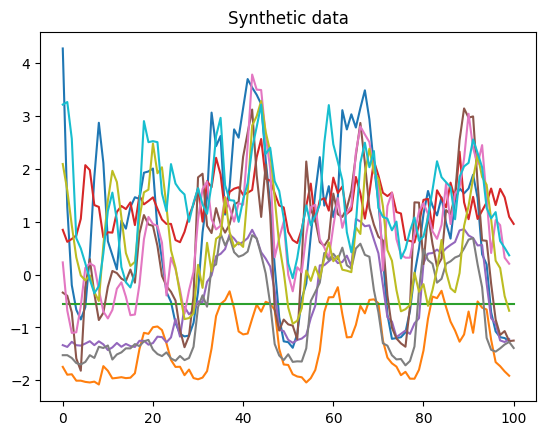

In [105]:
import numpy as np
synth_data = []

plt.title("Synthetic data")
with open(OUTPUT_PATH, "r") as f:
    for row in f:
        synth_data.append(np.array(json.loads(row)))
        plt.plot(synth_data[-1])

## Compare to the closest record in training data

In [91]:
train_data = []
with open(TRAIN_PATH, "r") as f:
    for row in f:
        train_data.append(np.array(json.loads(json.loads(row)["messages"][-1]["content"])["consumption"]))

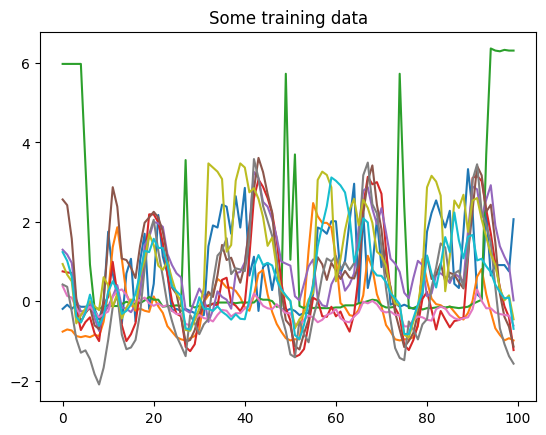

In [106]:
plt.title("Some training data")
for i in range(10):
    plt.plot(train_data[i])

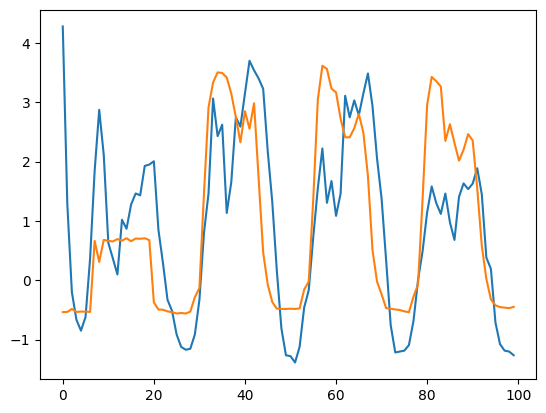

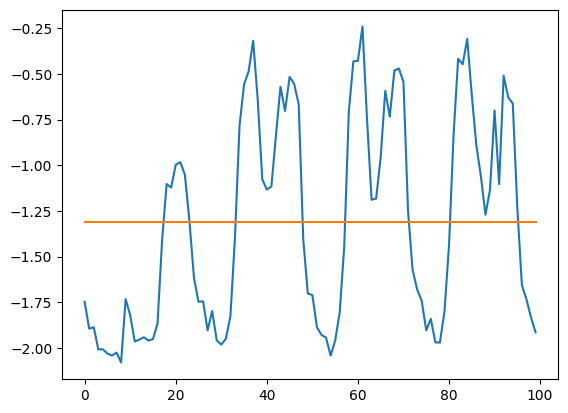

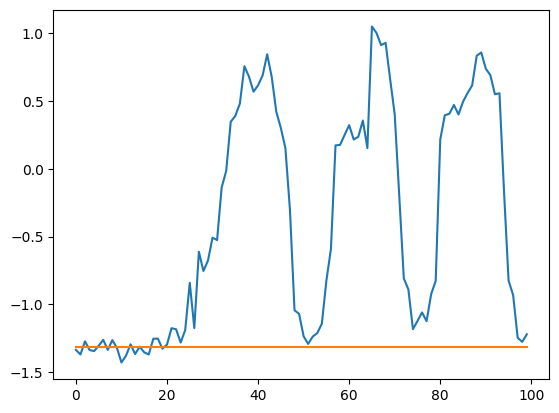

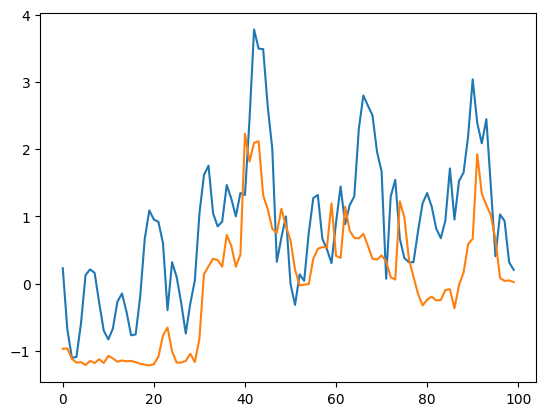

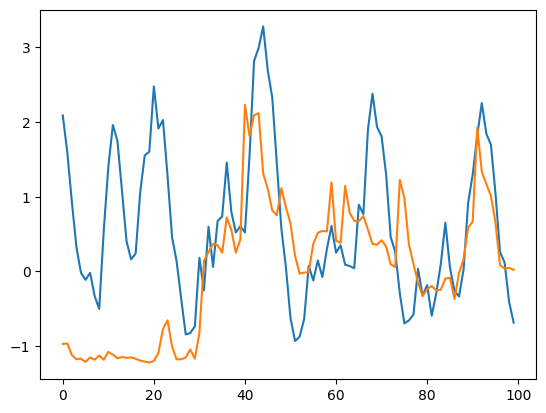

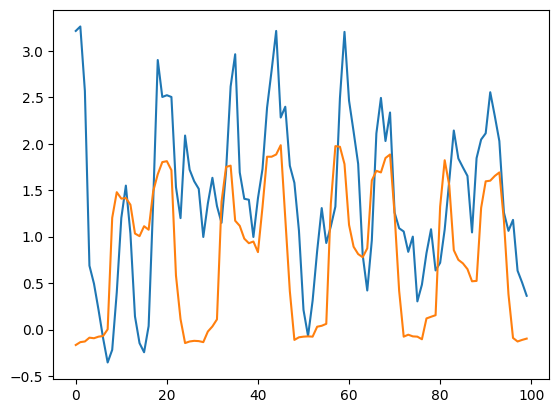

In [97]:
def closest(synthetic: np.ndarray, training: list[np.ndarray]) -> np.ndarray:
    current_closest = training[0]
    current_dist = np.sum(np.square(synthetic-current_closest))
    for training in training[1:]:
        dist = np.sum(np.square(synthetic-training))
        if dist < current_dist:
            current_closest = training
    return current_closest

for synth in synth_data:
    try:
        close = closest(synth, train_data)
        plt.plot(synth)
        plt.plot(close)
        plt.show()
    except:
        pass